### Plotting Test
Alex is using this Jupyter notebook to test the plotting + print statements from query.py.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lsst.rsp import get_tap_service
import query_helpers as q

##### Testing object classifcation
There are two ways this classification function works:
1. Providing orbit parameters, returning a corresponding object type
2. Providing an object type, reutrning corresponding orbit parameters

In [5]:
# 1
input_params = {
        "q_cutoff_min": None, 
        "q_cutoff": None,
        "a_cutoff_min": None, 
        "a_cutoff": None,
        "e_cutoff_min": None, 
        "e_cutoff": None,
        "t_cutoff_min": 2.0,
        "t_cutoff": 3.0}

object_type = q.type_classification(input_params = input_params)
print(object_type)

#2
params = q.type_classification(object_type = "JFC")
print(params)

JFC
{'t_cutoff_min': 2.0, 't_cutoff': 3.0}


Now that know our classification works, let's try making a full query. 

In [7]:
# testing with NEOs
query, object_type = q.make_query_general(object_type = "NEO")
print(query)
print(object_type)

query, object_type = q.make_query_general(object_type = "NEO", join = 'Diasource')
print(query)
print(object_type)

query, object_type = q.make_query_general(q_cutoff=1.3, a_cutoff=4.0, e_cutoff = 1.0, join = 'Diasource')
print(query)
print(object_type) 


SELECT mpc.incl, mpc.q, mpc.e, mpc.ssObjectID FROM dp03_catalogs_10yr.MPCORB as mpc
    WHERE mpc.q < 1.3 AND mpc.e < 1.0 AND mpc.q/(1-mpc.e) < 4.0;
NEO
SELECT mpc.incl, mpc.q, mpc.e, mpc.ssObjectID, dias.magTrueVband, dias.band FROM dp03_catalogs_10yr.MPCORB as mpc
    INNER JOIN dp03_catalogs_10yr.DiaSource AS dias ON mpc.ssObjectId = dias.ssObjectId
    WHERE mpc.q < 1.3 AND mpc.e < 1.0 AND mpc.q/(1-mpc.e) < 4.0;
NEO
SELECT mpc.incl, mpc.q, mpc.e, mpc.ssObjectID, dias.magTrueVband, dias.band FROM dp03_catalogs_10yr.MPCORB as mpc
    INNER JOIN dp03_catalogs_10yr.DiaSource AS dias ON mpc.ssObjectId = dias.ssObjectId
    WHERE mpc.q < 1.3 AND mpc.e < 1.0 AND mpc.q/(1-mpc.e) < 4.0;
NEO


In [46]:
# running the query
NEO_objects_table = q.run_query(query)

Job phase is ERROR


DALQueryError: Query Error: PSQLException:The connection attempt failed.

In [ ]:
# Adding calculated + object_type columns to data table
a = q.calc_semimajor_axis(NEO_objects_table['q'], NEO_objects_table['e'])
NEO_objects_table['a'] = a
NEO_objects_table['object_type'] = object_type

print(NEO_objects_table[0:5]) # print first few rows 
print(NEO_objects_table.columns)

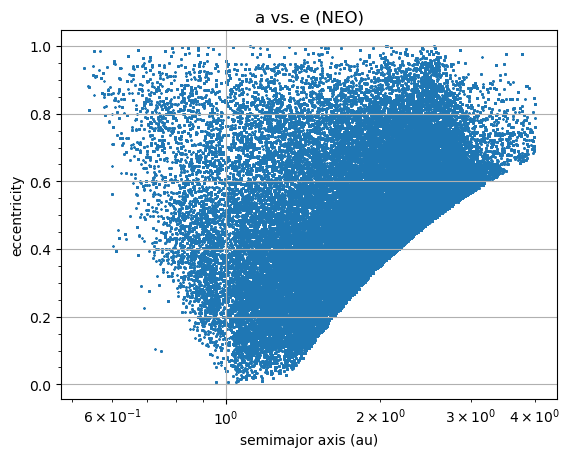

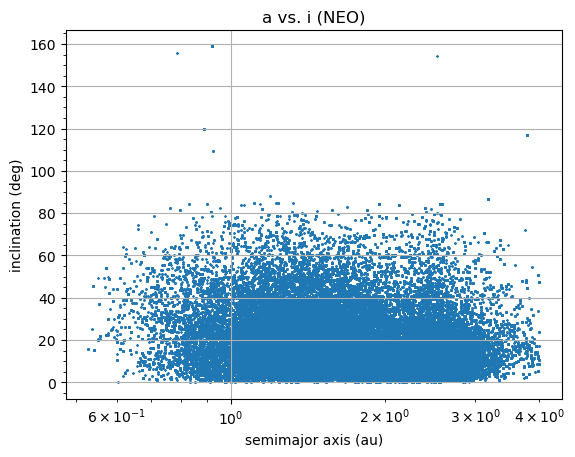

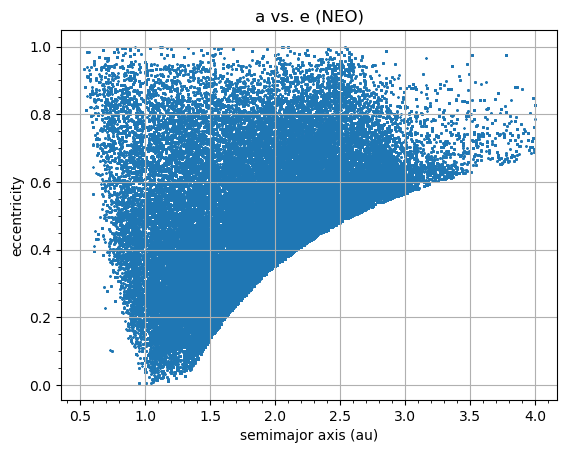

In [34]:
q.plot_data(NEO_objects_table)

# # Manual Plotting Code 
fig, ax = plt.subplots()
# plt.xlim([0., 4.])
# plt.ylim([0., 1.])
ax.scatter(NEO_objects_table["a"], NEO_objects_table["e"], s=0.1) # a vs. i
# ax.set_xscale('log')
ax.set_xlabel('semimajor axis (au)')
ax.set_ylabel('eccentricity')
ax.set_title("a vs. e (NEO)")
ax.minorticks_on()
ax.grid()
plt.show()

In [35]:
# q.type_counts(NEO_objects_table)
print(NEO_objects_table.columns)
df = NEO_objects_table.to_pandas()
print(df['object_type'].value_counts())
type(df['object_type'].value_counts())

<TableColumns names=('incl','q','e','ssObjectID','magTrueVband','band','a','object_type')>
object_type
NEO    2135926
Name: count, dtype: int64


pandas.core.series.Series

#### How many observations for each object? In what filters?

In [36]:
# # need to count observations for each unique object in SSO_id
# print(df['ssObjectID'].value_counts())
# # unique observations within each filter
# print(df['band'].value_counts())
# # count of unique observations for each unique object in SSO_id within each filter
# temp = df.groupby(['ssObjectID', 'band']).size().reset_index(name='obs_filter_count')
# print(df.groupby(['ssObjectID', 'band']).size().reset_index(name='obs_filter_count'))
# print(temp.columns)

observations_by_object_filter = q.obs_filter(df)

ssObjectID
-6531816816762911299    1708
-7495537061370576217    1316
-8960445666237157474    1084
 5885925787919145121     993
-3541095373223286452     991
                        ... 
 8210757616290374451       6
-5675138216577684964       6
-317670342693814751        6
-7554881316084645816       6
 4738261344712572538       6
Name: count, Length: 39470, dtype: int64


band
r    754794
i    686043
z    419419
g    275670
Name: count, dtype: int64


                 ssObjectID band  obs_filter_count
0      -9222952578217572358    g                 4
1      -9222952578217572358    i                11
2      -9222952578217572358    r                12
3      -9222952578217572358    z                 6
4      -9222820784385736130    g                 7
...                     ...  ...               ...
153755  9222765823057774610    z                 4
153756  9222996671474961129    g                 1
153757  9222996671474961129    i                 5
153758  9222996671474961129    r                 7
153759  9222996671474961129    z                 4

[153760 rows x 3 columns]
Index(['ssObjectID', 'band', 'obs_filter_count'], dtype='object')


#### What is the average magnitude range? Does any object have an unusually large range?

Want to group everything by its object type, then group the observations by object, then want to get the min/max brightnesses from each object, then want to get average min/max values, then if something is more than one std.dev away, want to call it out. 

In [13]:
df.columns

Index(['incl', 'q', 'e', 'ssObjectID', 'magTrueVband', 'band', 'a',
       'object_type'],
      dtype='object')

In [14]:
"""
Function groups everything by object type, observations by unique object, gets min/max mags
"""

# 1. Group observations by object type, by ssObjectID, get the min/max/mean magnitudes
grouped_obs_data = df.groupby(['object_type', 'ssObjectID']).agg(
    mag_min = ('magTrueVband', 'min'), 
    mag_max = ('magTrueVband', 'max'), 
    mag_mean = ('magTrueVband', 'mean')
)
grouped_obs_data = grouped_obs_data.reset_index() # groupby turns 'object_type' and 'ssObjectID' into indeces, this turns them back into columns
# print(grouped_obs_data) # degbugging

# 2. Create ranges column from min/max magnitudes, get standard deviation of ranges. 
# want to look at when the range has a larger spread than normal, so want to get the std. deviation of the range
mag_range = grouped_obs_data["mag_max"] - grouped_obs_data["mag_min"]
# print(mag_range) # debugging
grouped_obs_data['mag_range'] = mag_range
print("Standard Deviation of Range:", np.std(mag_range))
print("Mean Range:", np.mean(mag_range))

# 3. Need to check which ranges are above change criterion. Using mean and std. deviation by object_type. 
large_criterion = np.mean(mag_range) + (np.std(mag_range)*2)
print(f"Large range criterion:", large_criterion)
filtered_large_ranges = grouped_obs_data[grouped_obs_data['mag_range'] > large_criterion]
# print(filtered_large_ranges) # debugging
# print(filtered_large_ranges.columns) #debugging

# 4. Rearranging dataframe so magnitude ranges are in descending order (largest at the top).
sorted_filt_lrg_ranges = filtered_large_ranges.sort_values(by='mag_range', ascending=False)
# print(sorted_filt_lrg_ranges) # debugging

      object_type           ssObjectID    mag_min    mag_max   mag_mean
0             NEO -9222952578217572358  20.865181  28.316063  22.341082
1             NEO -9222820784385736130  21.404852  29.954420  25.140797
2             NEO -9222809672762914664  29.152020  31.880566  30.732315
3             NEO -9222638543944259679  20.660261  20.916206  20.807749
4             NEO -9222469573562197566  21.441607  25.298536  22.376635
...           ...                  ...        ...        ...        ...
39465         NEO  9221626825731835023  21.376930  26.843601  23.258450
39466         NEO  9222267589414335277  18.893867  23.640882  21.959656
39467         NEO  9222476822316093977  18.088520  24.029242  22.102621
39468         NEO  9222765823057774610  27.979145  29.599825  28.464285
39469         NEO  9222996671474961129  22.383114  23.973074  22.934273

[39470 rows x 5 columns]


0        7.450882
1        8.549568
2        2.728546
3        0.255945
4        3.856930
           ...   
39465    5.466671
39466    4.747015
39467    5.940722
39468    1.620680
39469    1.589960
Length: 39470, dtype: float32
Standard Deviation of Range: 2.377028226852417
Mean Range: 4.574746


Large range criterion: 9.328802
      object_type           ssObjectID    mag_min    mag_max   mag_mean  \
14            NEO -9219171728267255250  19.298977  28.877172  22.183498   
27            NEO -9216053751937257784  20.393387  30.031639  28.477058   
83            NEO -9183688667903258474  17.940182  29.041962  23.310806   
120           NEO -9166777493374345134  17.262751  28.463610  21.906799   
157           NEO -9148078086610606641  17.772121  28.941460  22.768671   
...           ...                  ...        ...        ...        ...   
39335         NEO  9158986482348813653  20.252665  30.635691  27.541515   
39377         NEO  9181766263904750082  21.245619  30.896566  24.534302   
39384         NEO  9183757900162982328  21.003494  30.338608  25.287655   
39414         NEO  9197445048663524213  18.193398  28.267920  21.568472   
39442         NEO  9208298150249762471  17.683380  27.085598  20.792793   

       mag_range  
14      9.578196  
27      9.638252  
83     11.

      object_type           ssObjectID    mag_min    mag_max   mag_mean  \
17900         NEO  -857702272249738670  16.754587  30.988918  25.396742   
29067         NEO  4381593234080338559  19.688309  33.831173  29.809322   
24205         NEO  2116498636741265465  18.195284  32.258026  26.781109   
12590         NEO -3364441727545846004  16.662918  30.719837  23.613773   
31422         NEO  5491202019942316220  16.118584  30.082521  21.996487   
...           ...                  ...        ...        ...        ...   
22943         NEO  1514112515638312531  20.118761  29.451569  23.284670   
28762         NEO  4249502074685941671  22.631592  31.963724  26.929041   
20118         NEO   234009041762893965  21.395878  30.727772  27.495180   
835           NEO -8854280172602825843  22.014624  31.345079  25.095337   
25736         NEO  2806174452006709662  22.494293  31.823355  27.064703   

       mag_range  
17900  14.234331  
29067  14.142864  
24205  14.062742  
12590  14.056919  
3142

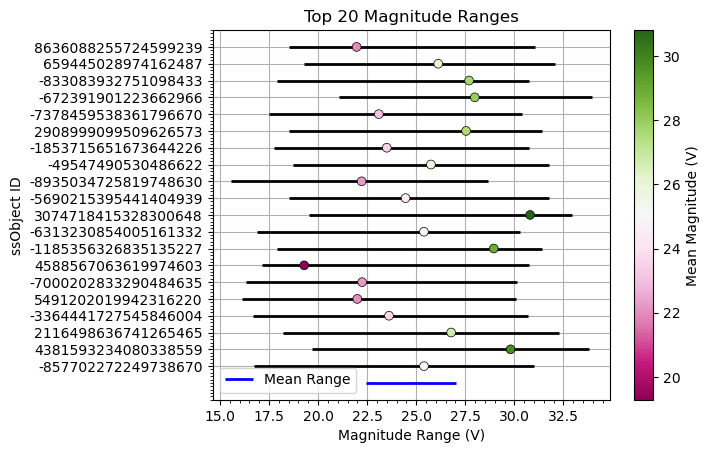

In [25]:
# getting top 10 ranges
top_srtd_filt_lrg_ranges = sorted_filt_lrg_ranges.iloc[:20,:]
top_ranges = top_srtd_filt_lrg_ranges.copy()
top_ranges['y_spacing'] = range(1, len(top_ranges) + 1) 
# print(top_ranges) #degbugging


# For the largest objects, want to visualize their ranges
fig, ax = plt.subplots()
ax.hlines(data = top_ranges, y = 'y_spacing', xmin = 'mag_min', xmax = 'mag_max', color = "black", linewidth = 2, zorder = 2, label = None)

# adding reference line
x_center = (top_ranges['mag_min'].min() + top_ranges['mag_max'].max()) / 2
xmin_ref = x_center - (np.mean(mag_range/2))
xmax_ref = x_center + (np.mean(mag_range/2))
ax.hlines(y = 0, xmin = xmin_ref, xmax = xmax_ref, color = "blue", linewidth = 2, label = "Mean Range") #want this to be in the center of the plot
# print("Mean Range:", np.mean(mag_range))
sc = ax.scatter(data = top_ranges, x = 'mag_mean', y = 'y_spacing', s = 40, marker='o', edgecolors = "black", linewidth = 0.5, c='mag_mean', cmap = 'PiYG', zorder = 3, label = None)
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Mean Magnitude (V)')
ax.set_xlabel('Magnitude Range (V)')
ax.set_ylabel('ssObject ID')
ax.set_title("Top 20 Magnitude Ranges")
ax.set_yticks(top_ranges['y_spacing'])
ax.set_yticklabels(top_ranges['ssObjectID'])
ax.minorticks_on()
ax.grid(zorder = 1)
plt.legend(loc="lower left")
plt.show()


# plt.scatter('x', 'y', s='size', c='density', data=df, alpha=0.5, cmap='Blues')

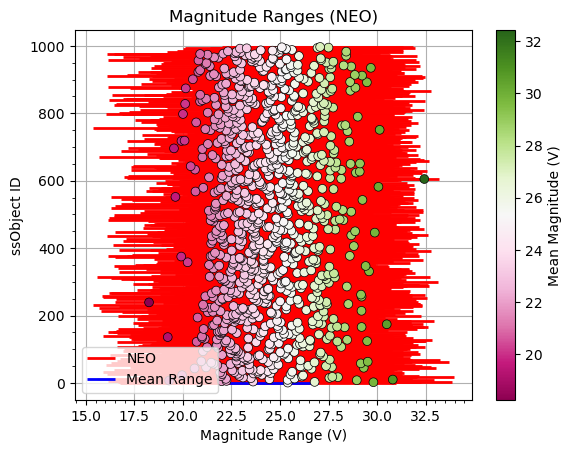

In [32]:
# just plotting all of the NEOs above 2 sigma
data_table = sorted_filt_lrg_ranges

top_srtd_filt_lrg_ranges = sorted_filt_lrg_ranges.iloc[:10,:]
top_ranges = data_table.copy()
top_ranges['y_spacing'] = range(1, len(top_ranges) + 1) 
# print(top_ranges) #degbugging

color_map = {
    "NEO": "red",
    "TNO": "blue",
    "Centaur": "green",
    "MBA": "orange",
    "Jtrojan": "purple",
    "LPC": "brown",
    "Ntrojan": "pink"
}

color = color_map.get(object_type, "gray")  # fallback to 'gray' if type unknown
# For the largest objects, want to visualize their ranges
fig, ax = plt.subplots()
ax.hlines(data = top_ranges, y = 'y_spacing', xmin = 'mag_min', xmax = 'mag_max', color = color, linewidth = 2, zorder = 2, label = object_type)

# adding reference line
x_center = (top_ranges['mag_min'].min() + top_ranges['mag_max'].max()) / 2
xmin_ref = x_center - (np.mean(mag_range/2))
xmax_ref = x_center + (np.mean(mag_range/2))
ax.hlines(y = 0, xmin = xmin_ref, xmax = xmax_ref, color = "blue", linewidth = 2, label = "Mean Range") #want this to be in the center of the plot
# print("Mean Range:", np.mean(mag_range))
sc = ax.scatter(data = top_ranges, x = 'mag_mean', y = 'y_spacing', s = 40, marker='o', edgecolors = "black", linewidth = 0.5, c='mag_mean', cmap = 'PiYG', zorder = 3, label = None)
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Mean Magnitude (V)')
ax.set_xlabel('Magnitude Range (V)')
ax.set_ylabel('ssObject ID')
ax.set_title("Magnitude Ranges")
# ax.set_yticks(top_ranges['y_spacing'])
# ax.set_yticklabels(top_ranges['ssObjectID'])
ax.minorticks_on()
ax.grid(zorder = 1)
plt.legend(loc="lower left")
plt.show()

In [26]:
# sorted_filt_lrg_ranges.columns

# q.mag_range_plot(sorted_filt_lrg_ranges, number = 5)
# q.mag_range_plot(sorted_filt_lrg_ranges, number = 40)
# q.mag_range_plot(sorted_filt_lrg_ranges, number = None)